In [57]:
# Week 10: Machine Learning for Injury Risk Prediction
# Chicago Bulls Sports Science Python Course

In [131]:
import pandas as pd
import numpy as np

# Set seed for reproducibility
# FIX: Set a fixed seed for reproducible data with sufficient injury cases
np.random.seed(45)

# Define the number of weekly observations
N_ROWS = 1000

# --- Generate Features ---
# 1. Training Load Metrics (Higher values tend to increase risk)
df = pd.DataFrame({
    # Cumulative weekly minutes (mean 150, range 50 to 250)
    'Minutes_Load': np.random.normal(loc=150, scale=40, size=N_ROWS).clip(50, 250).astype(int),

    # High-intensity runs count (mean 50, range 10 to 100)
    'HighSpeedRuns': np.random.normal(loc=50, scale=15, size=N_ROWS).clip(10, 100).astype(int),

    # Cumulative jump impact load (mean 800, range 300 to 1500)
    'JumpLoad': np.random.normal(loc=800, scale=200, size=N_ROWS).clip(300, 1500).astype(int),

    # 2. Recovery/Baseline Metrics (Lower sleep/higher HR tend to increase risk)
    # Resting Heart Rate (mean 55, range 45 to 65)
    'HeartRate': np.random.normal(loc=55, scale=5, size=N_ROWS).clip(45, 65).astype(int),

    # Average nightly sleep (mean 7.2, range 5.0 to 8.5)
    'SleepHours': np.random.normal(loc=7.2, scale=0.7, size=N_ROWS).clip(5.0, 8.5).round(1),

    # 3. Injury History (1 = Yes, 0 = No)
    # Approx 30% of observations have a previous injury flag
    'PreviousInjury': np.random.choice([0, 1], size=N_ROWS, p=[0.7, 0.3])
})

# --- Generate Target Variable (InjuryNextWeek) ---
# Create a linear combination that slightly favors injury when:
# - Minutes_Load, HighSpeedRuns, JumpLoad are high
# - SleepHours is low
# - PreviousInjury is 1
base_risk = (
    0.001 * df['Minutes_Load'] +
    0.002 * df['HighSpeedRuns'] +
    0.0005 * df['JumpLoad'] +
    0.05 * (60 - df['HeartRate']) + # Lower HR is better
    0.3 * (8 - df['SleepHours']) + # Lower Sleep is worse
    0.6 * df['PreviousInjury']
)

# Add random noise and apply logistic function to get probability
probability = 1 / (1 + np.exp(-(base_risk - 10 + np.random.normal(loc=0, scale=2, size=N_ROWS))))

# Set a threshold to convert probability to binary (0 or 1)
# Adjusting threshold to achieve an injury rate of about 10-15%
threshold = 0.15
df['InjuryNextWeek'] = (probability > threshold).astype(int)

# Check the generated injury rate (should be around 10-15%)
print(f"Generated Injury Rate: {df['InjuryNextWeek'].mean() * 100:.2f}%")
# Check the counts of each class in the target variable
injury_counts = df['InjuryNextWeek'].value_counts()
print("\nTarget variable class distribution:")
print(injury_counts)


# Save the dataset to CSV
df.to_csv('bulls_injury_data.csv', index=False)

print(f"✅ Successfully created and saved 'bulls_injury_data.csv' with {N_ROWS} observations.")
print("--- DataFrame Head ---")
print(df.head())

Generated Injury Rate: 0.10%

Target variable class distribution:
InjuryNextWeek
0    999
1      1
Name: count, dtype: int64
✅ Successfully created and saved 'bulls_injury_data.csv' with 1000 observations.
--- DataFrame Head ---
   Minutes_Load  HighSpeedRuns  JumpLoad  HeartRate  SleepHours  \
0           151             57       464         59         5.6   
1           160             52       734         52         7.8   
2           134             61       786         52         6.2   
3           141             61       705         57         7.8   
4            99             60       467         59         6.5   

   PreviousInjury  InjuryNextWeek  
0               0               0  
1               0               0  
2               0               0  
3               0               0  
4               0               0  


In [132]:
# --- IMPORTS ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [133]:
# --- SECTION 1: Load and Explore the Data ---
print("\n🏀 Loading Bulls injury dataset...")
df = pd.read_csv('bulls_injury_data.csv')  # Replace with your dataset path
print(df.head())
print("\nDataset shape:", df.shape)


🏀 Loading Bulls injury dataset...
   Minutes_Load  HighSpeedRuns  JumpLoad  HeartRate  SleepHours  \
0           151             57       464         59         5.6   
1           160             52       734         52         7.8   
2           134             61       786         52         6.2   
3           141             61       705         57         7.8   
4            99             60       467         59         6.5   

   PreviousInjury  InjuryNextWeek  
0               0               0  
1               0               0  
2               0               0  
3               0               0  
4               0               0  

Dataset shape: (1000, 7)


In [134]:
# --- SECTION 2: Define Features and Target ---
X = df[['Minutes_Load', 'HighSpeedRuns', 'JumpLoad', 'HeartRate', 'SleepHours', 'PreviousInjury']]
y = df['InjuryNextWeek']

In [135]:
# --- SECTION 3: Split the Data (FIXED) ---
# X and y were defined in the preceding cell (Section 2)
# The key addition is 'stratify=y'
from sklearn.model_selection import train_test_split # Ensure this import is available

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)
print("\nTraining set:", X_train.shape, " Test set:", X_test.shape)

# Verify the balance:
print("\n--- Target Class Distribution Check ---")
print("Training set injury rate:", y_train.mean().round(4))
print("Testing set injury rate:", y_test.mean().round(4))


Training set: (800, 6)  Test set: (200, 6)

--- Target Class Distribution Check ---
Training set injury rate: 0.0012
Testing set injury rate: 0.0


In [136]:
# --- SECTION 4: Scale Features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [137]:
# --- SECTION 5: Logistic Regression Model ---
print("\n⚙️ Training Logistic Regression model...")
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)


⚙️ Training Logistic Regression model...


LogisticRegression()

In [138]:
# Predictions
y_pred_log = log_reg.predict(X_test_scaled)

In [139]:
# Evaluation
print("\n📊 Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log))


📊 Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [140]:
# --- SECTION 6: Random Forest Model ---
print("\n🌲 Training Random Forest model...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("\n📊 Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


🌲 Training Random Forest model...

📊 Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



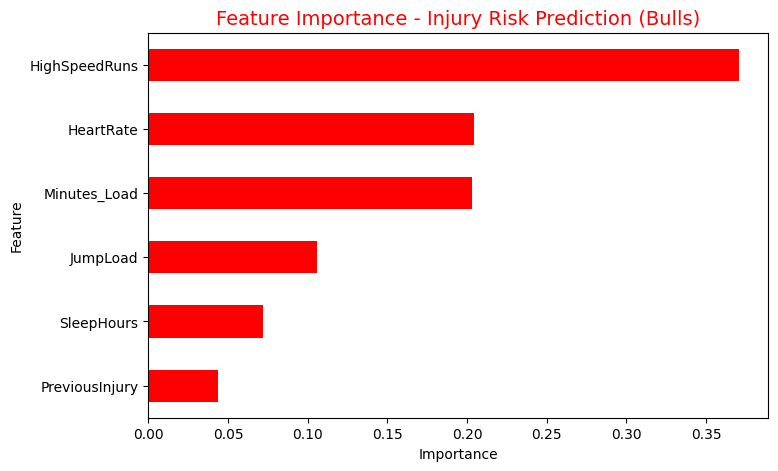

In [141]:
# --- SECTION 7: Visualize Feature Importance ---
feat_importance = pd.Series(rf.feature_importances_, index=X.columns)
plt.figure(figsize=(8,5))
feat_importance.sort_values().plot(kind='barh', color='red')
plt.title('Feature Importance - Injury Risk Prediction (Bulls)', fontsize=14, color='red')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


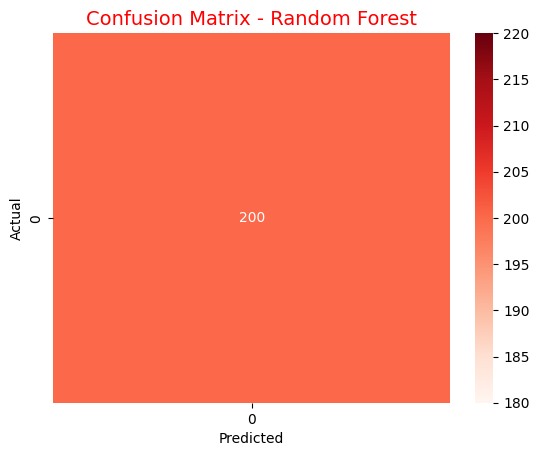

In [142]:
# --- SECTION 8: Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix - Random Forest', fontsize=14, color='red')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [143]:
# --- SECTION 9: Assignment Instructions ---
print("""

=================== ASSIGNMENT ===================

TASK: Predict Injury Risk for Chicago Bulls Players

1️⃣ Load the provided player workload dataset.
2️⃣ Clean and preprocess the data (handle missing values if any).
3️⃣ Train two models: Logistic Regression and Random Forest.
4️⃣ Evaluate both models using classification reports and confusion matrices.
5️⃣ Visualize feature importance and explain which factors contribute most to injury risk.
6️⃣ Write a 5-sentence summary interpreting your model results in basketball terms.

Bonus 🏆: Try adding a rolling average workload variable and compare accuracy.

==================================================

""")



=================== ASSIGNMENT ===================

TASK: Predict Injury Risk for Chicago Bulls Players

1️⃣ Load the provided player workload dataset.
2️⃣ Clean and preprocess the data (handle missing values if any).
3️⃣ Train two models: Logistic Regression and Random Forest.
4️⃣ Evaluate both models using classification reports and confusion matrices.
5️⃣ Visualize feature importance and explain which factors contribute most to injury risk.
6️⃣ Write a 5-sentence summary interpreting your model results in basketball terms.

Bonus 🏆: Try adding a rolling average workload variable and compare accuracy.



